In [1]:
import pandas as pd
import numpy as np
import joblib
import sys
sys.path.append('../')

from premier_league import constants
if constants.RUN_DATA_EXPECTATIONS:
    from expectations_helpers import (
        AutoGreatExpectations,
        view_full_suite,
        view_suite_summary,
        save_expectations,
        load_expectations,
        validate_data
    )
from premier_league import (
    preprocessing,
    preprocessing_helpers,
    training,
    evaluation,
    prediction,
    data_extraction,
    visualisations,
    s3_helpers,
)

In [2]:
import importlib
importlib.reload(constants)


<module 'premier_league.constants' from '/Users/david@inawisdom.com/Documents/Training/premier_league/notebooks/../premier_league/constants.py'>

In [17]:
# Timestamp for current run
current_timestamp = s3_helpers.get_current_date_time()
current_timestamp

'2023-11-09 05:30:36'

In [3]:
df = s3_helpers.grab_data_s3(constants.TRAINING_DATA_LOCATION)
df = df[constants.COLUMNS_REQ]

In [4]:
df.head()

,season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1995-96,19/08/95,Aston Villa,Man United,3.0,1.0,H
1,1995-96,19/08/95,Blackburn,QPR,1.0,0.0,H
2,1995-96,19/08/95,Chelsea,Everton,0.0,0.0,D
3,1995-96,19/08/95,Liverpool,Sheffield Weds,1.0,0.0,H
4,1995-96,19/08/95,Man City,Tottenham,1.0,1.0,D


### Set up data validation

In [5]:
if constants.RUN_DATA_EXPECTATIONS:
    ge_class = AutoGreatExpectations(df)

In [6]:
if constants.RUN_DATA_EXPECTATIONS:
    ge_data = ge_class.generate_expectations(verbose=False)

In [7]:
if constants.RUN_DATA_EXPECTATIONS:
    view_suite_summary(ge_data)

In [8]:
if constants.RUN_DATA_EXPECTATIONS:
    save_expectations(ge_data, constants.exp_loc)

### Validate data

In [9]:
if constants.RUN_DATA_EXPECTATIONS:
    data_expectations = load_expectations(constants.exp_loc)

In [10]:
if constants.INITIAL_DATA_LOAD:
    full_data = data_extraction.load_all_data(
        constants.TRAINING_DATA_LOCATION,
        constants.COLUMNS_REQ
    )
else:
    full_data = s3_helpers.grab_data_s3(
        constants.TRAINING_DATA_LOCATION)


In [11]:
full_data = data_extraction.add_new_data(
    full_data, 
    constants.COLUMNS_REQ,
    constants.TRAINING_DATA_LOCATION
)

Data saved at app_data/training_data_full.csv


In [12]:
if constants.RUN_DATA_EXPECTATIONS:
    validation_results = validate_data(full_data, data_expectations)

### Preprocessing

In [13]:
df = s3_helpers.grab_data_s3(constants.TRAINING_DATA_LOCATION)
df = df[constants.COLUMNS_REQ]
df.head()

,season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1995-96,19/08/95,Aston Villa,Man United,3.0,1.0,H
1,1995-96,19/08/95,Blackburn,QPR,1.0,0.0,H
2,1995-96,19/08/95,Chelsea,Everton,0.0,0.0,D
3,1995-96,19/08/95,Liverpool,Sheffield Weds,1.0,0.0,H
4,1995-96,19/08/95,Man City,Tottenham,1.0,1.0,D


In [14]:
transformers = preprocessing.fit_transformers(
    df
)

In [57]:
s3_helpers.save_transformer_s3_pickle(
    transformers, 
    constants.TRANSFORMER_PATH
)

Transformer object is saved to S3 bucket premier-league-app at app_data/transformers/transformer_v2.pkl


In [36]:
transformed_data = preprocessing.transform_data(
    df, transformers
)

In [ ]:
#transformed_data = transformed_data.drop(['HomeTeam', 'AwayTeam', 'season'], axis=1)

In [37]:
training_data, testing_data = preprocessing.split_data(transformed_data)

In [38]:
training_data.shape

(8600, 33)

In [39]:
testing_data.shape

(2150, 33)

In [40]:
training_data.head(2)

,season,HomeTeam,AwayTeam,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,MW,HTFormPts,ATFormPts,HTGD,ATGD,DiffPts,DiffFormPts,HomeLeaguePosition,AwayLeaguePosition,LeaguePositionDiff,MatchDayDay,MatchDayMonth,MatchDayDate
0,2016-17,Bournemouth,Middlesbrough,0,45.0,23.0,59.0,39.0,1.060606,0.727273,L,L,D,D,D,L,W,D,W,L,33.0,8,2,-0.424242,-0.484848,0.333333,0.181818,12,14,-2,Saturday,April,22
1,1997-98,Barnsley,Wimbledon,0,22.0,28.0,62.0,30.0,0.814815,1.185185,L,L,D,W,L,W,W,D,L,D,27.0,4,8,-1.481481,-0.074074,-0.370370,-0.148148,16,12,4,Saturday,February,28


### Model Training

In [42]:
target_column = 'FTR'

In [43]:
hyperparameters = training.optimise_hyperparameters(
    training_data,target_column
)

Entering fmin
CatBoost initialized                                                                                                
Fitting model                                                                                                       
Loss: -0.5343023255813953                                                                                           
CatBoost initialized                                                                                                
Fitting model                                                                                                       
Loss: -0.5186046511627908                                                                                           
CatBoost initialized                                                                                                
Fitting model                                                                                                       
Loss: -0.5238372093023256                         

In [44]:
print(hyperparameters)

{'learning_rate': 0.04000000000000001, 'iterations': 850, 'max_depth': 14}


In [46]:
classifier = training.train_model(
    training_data[[col for col in training_data if col != target_column]],
    training_data[target_column],
    hyperparameters = hyperparameters
)

In [49]:
s3_helpers.save_transformer_s3_pickle(
    classifier, 
    constants.CLASS_MODEL_NAME,
    is_transformer=False
)

Transformer object is saved to S3 bucket premier-league-app at app_data/models/classifier_v2.pkl


### Prediction

In [58]:
y_test = testing_data[target_column]
x_test = testing_data[[col for col in testing_data if col != target_column]]

In [59]:
predictions = prediction.predict(x_test, classifier)

### Evaluation

In [60]:
evaluation_metrics = evaluation.evaluate_model(predictions, y_test)

In [61]:
evaluation_metrics

{'mcc': 0.2505413643655009,
 'accuracy': 0.54,
 'f1': 0.4879060442805164,
 'confusion_matrix': [[816, 36, 143], [329, 49, 163], [285, 33, 296]]}

### Part 2: Predict Score

In [62]:
transformed_data = prediction.add_match_result(
    transformed_data, classifier, df )

In [63]:
transformed_data.to_csv('../data/transformed_data_cc.csv',index=False)

In [64]:
transformed_data.shape

(10750, 36)

In [65]:
training_data, testing_data = preprocessing.split_data(transformed_data)

In [66]:
hyperparameters = training.optimise_hyperparameters(
    training_data.drop(['FTR','FTAG'], axis=1),
    'FTHG',
    classification=False
)

Entering fmin
CatBoost initialized                                                                                                
Fitting model                                                                                                       
Loss: 1.393037942894074                                                                                             
CatBoost initialized                                                                                                
Fitting model                                                                                                       
Loss: 1.387183368431533                                                                                             
CatBoost initialized                                                                                                
Fitting model                                                                                                       
Loss: 1.3911536734802206                          

In [67]:
regressor_1 = training.train_model(
    training_data.drop(['FTR', 'FTHG','FTAG'], axis=1),
    training_data['FTHG'],
    classification=False,
    verbose=False
)

In [68]:
s3_helpers.save_transformer_s3_pickle(
    regressor_1, 
    constants.HOME_MODEL_NAME,
    is_transformer=False
)

Transformer object is saved to S3 bucket premier-league-app at app_data/models/home_regress_model_v2.pkl


In [69]:
hyperparameters = training.optimise_hyperparameters(
    training_data.drop(['FTR', 'FTHG'], axis=1),
    'FTAG',
    classification=False
)

Entering fmin
CatBoost initialized                                                                                                
Fitting model                                                                                                       
Loss: 1.1184066786339808                                                                                            
CatBoost initialized                                                                                                
Fitting model                                                                                                       
Loss: 1.1135075031378008                                                                                            
CatBoost initialized                                                                                                
Fitting model                                                                                                       
Loss: 1.1192159832581916                          

In [70]:
regressor_2 = training.train_model(
    training_data.drop(['FTR', 'FTHG','FTAG'], axis=1),
    training_data['FTAG'],
    classification=False,
    verbose=False
)

In [71]:
s3_helpers.save_transformer_s3_pickle(
    regressor_2, 
    constants.AWAY_MODEL_NAME,
    is_transformer=False
)

Transformer object is saved to S3 bucket premier-league-app at app_data/models/away_regress_model_v2.pkl


### Predict Home Goals

In [72]:
y_test = testing_data['FTHG']
x_test = testing_data.copy()

In [73]:
predictions_1 = prediction.predict(x_test, regressor_1)

In [74]:
evaluation_metrics = evaluation.evaluate_model(predictions_1, 
                                               y_test, classification=False)
evaluation_metrics

{'r2_score': -0.06820654958797912,
 'median_ae': 1.0,
 'mean_ae': 0.9511627906976744}

### Predict Away Goals

In [75]:
y_test = testing_data['FTAG']
x_test = testing_data.copy()

In [76]:
predictions_2 = prediction.predict(x_test, classifier)

In [77]:
evaluation_metrics = evaluation.evaluate_model(predictions_2, 
                                               y_test, classification=False)
evaluation_metrics

{'r2_score': -0.08543118079070577,
 'median_ae': 1.0,
 'mean_ae': 0.7906976744186046}

### Visualisations of results

In [78]:
x_test['Home Prediction'] = predictions_1
x_test['Away Prediction'] = predictions_2

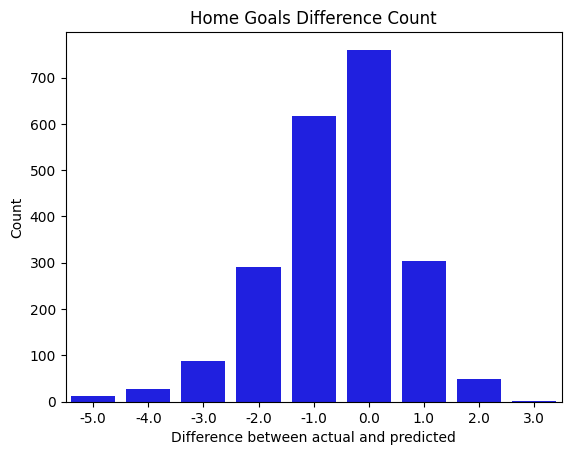

In [79]:
visualisations.histoplot(x_test, ha='Home')

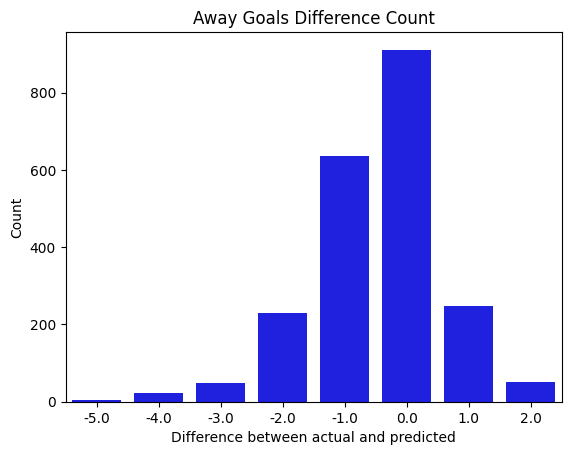

In [80]:
visualisations.histoplot(x_test, ha='Away')

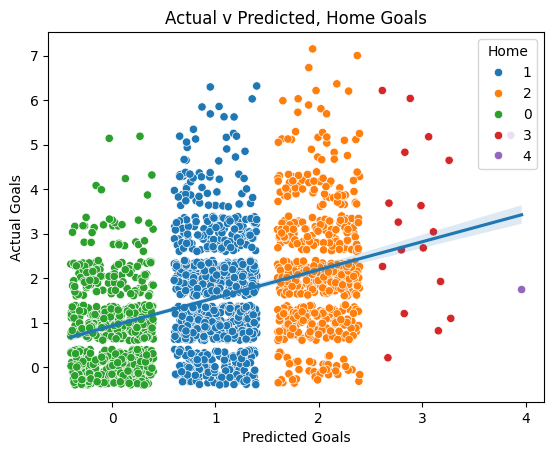

In [81]:
visualisations.actuals_predicted(x_test, ha='Home')

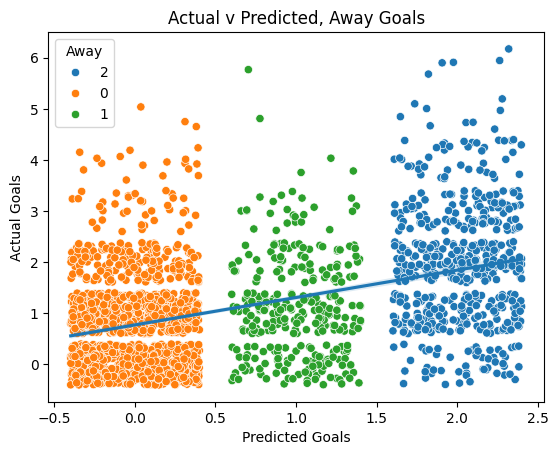

In [82]:
visualisations.actuals_predicted(x_test, ha='Away')

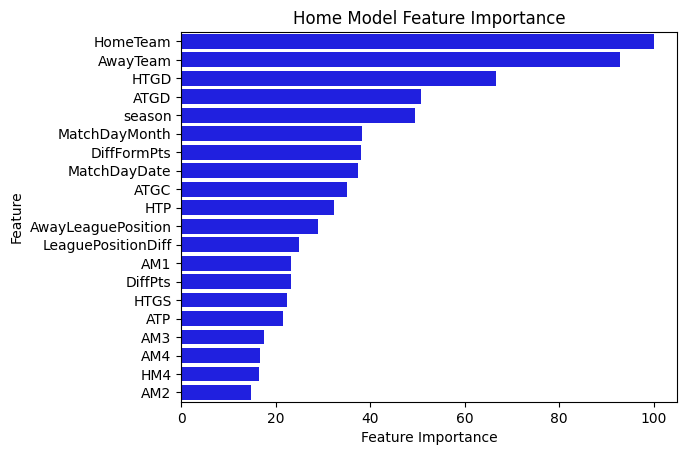

In [83]:
visualisations.plot_features(regressor_1, 'Home',n=20)

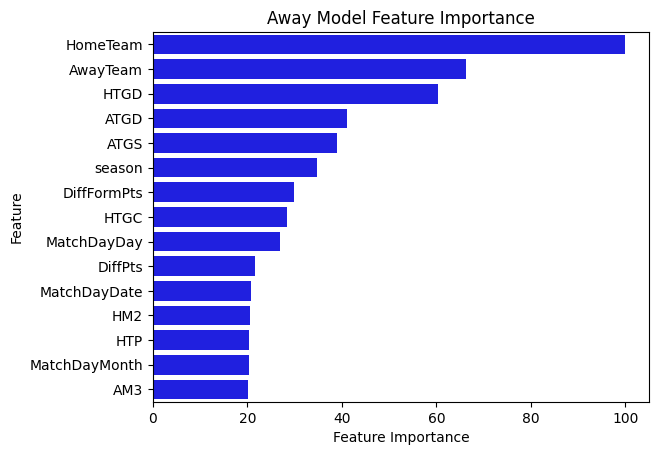

In [84]:
visualisations.plot_features(regressor_2, 'Away')